<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Lab_1_Feature_Extraction_and_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab. \#1. Feature Extraction and Machine Learning

## Problem Statement

The lab deals with comparison of two approaches to machine learning (ML) and computer vision (CV). The first approach is processing of hand-designed features, e.g. geometric features of objects in images, with an ML classification model. The second approach is using of the ML model for both, the automatic feature extraction and the following classification.

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples.

The hand-designed features can be extracted with standart tools in [scikit-learn](https://scikit-learn.org/1.5/modules/feature_extraction.html)

## Tasks and Requirements
* Check the [Linghtning framework](https://lightning.ai/docs/pytorch/stable/) (Level Up, Core API, Optional API section of the manual)
* Check the [ClearML](https://clear.ml/docs/latest/docs/integrations/pytorch_lightning/)
* Fill the table in the Results section and fill the Conclusion section

Bonus

* apply a t-SNE model to visualize both, the original images dataset, and the designed table dataset with hand-extracted features from the images

# Import and Install Libraries

In [1]:
!pip install pytorch-lightning clearml

In [24]:
#Pytorch modules
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import datasets, transforms

#sklearn
from sklearn.metrics import confusion_matrix

#Numpy
import numpy as np

#Pandas
import pandas as pd

#Lightning & logging
import pytorch_lightning as pl
from pytorch_lightning import Trainer

#Data observation
import os
from pathlib import Path

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Logging
from clearml import Task

# Set the Model

## Simulation Settings

Check the current directory

In [3]:
os.getcwd() #returns the current working directory

'/content'

Paths and initializations of the weights

In [4]:
# # Path to the folder where the dataset is saved
# DATASET_PATH = os.environ.get("PATH_DATASET", "data/")
# print(f'DATASET_PATH: {DATASET_PATH}')

# # Path to the folder where the trained or pretrained models are saved
# CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models")
# print(f'CHECKPOINT_PATH: {CHECKPOINT_PATH}')

# os.makedirs(DATASET_PATH, exist_ok=True) #create the directory
# os.makedirs(CHECKPOINT_PATH, exist_ok=True) #create the directory

isINFERENCE = False # inference mode with downloading the saved weights
isPretrained = False # use the pretrained weights when training

# Function for setting the seed to implement parallel tests
seed = 42 # random seeds are 42, 0, 17, 9, 3
pl.seed_everything(seed)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO:lightning_fabric.utilities.seed:Seed set to 42


## Logging

To configure ClearML in your Colab environment, follow these steps:

---

*Step 1: Create a ClearML Account*
1. Go to the [ClearML website](https://clear.ml/).
2. Sign up for a free account if you don’t already have one.
3. Once registered, log in to your ClearML account.

---

*Step 2: Get Your ClearML Credentials*
1. After logging in, navigate to the **Settings** page (click on your profile icon in the top-right corner and select **Settings**).
2. Under the **Workspace** section, find your **+ Create new credentials**.
3. Copy these credentials for a Jupiter notebook into the code cell below.

---

*Step 3: Accessing the ClearML Dashboard*
1. Go to your ClearML dashboard (https://app.clear.ml).
2. Navigate to the **Projects** section to see your experiments.
3. Click on the experiment (e.g., `Lab_1`) to view detailed metrics, logs, and artifacts.

---

In [5]:
#Enter your code here to implement Step 2 as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


In [6]:
task = Task.init(project_name="CV-2025", task_name=f'Lab_1_seed={seed}')
print("ClearML is configured correctly!")

ClearML Task: created new task id=51a387ab1b174dccbf4c833fb840f9a6
2025-01-07 13:05:38,397 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/618999a0375142c182d4f155841c66b8/experiments/51a387ab1b174dccbf4c833fb840f9a6/output/log
ClearML is configured correctly!


## Dataset

Summary

In [7]:
DATASET = 'MNIST'
ns = {'train': 55000, 'val': 5000, 'test': 10000}

SIZE = 28 #image size
NUM_CLASSES = 10
CLASS_NAMES = ['zero' ,'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine']

Normalization parameters

In [8]:
mean = np.array([0.1307])
std  = np.array([0.3081])

Transforms

## Collect hyperparameters

In [69]:
#Model parameters
LOSS_FUN = 'CE'
ARCHITECTURE = 'MLP'
DO = 0.5 #dropout
lr = 0.0001 #
n = 2 # number of epochs

batch_size = 64
num_workers = 8

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roundRun = 5 #number of digits in the results performance

#Visualization
figSize = 5
nSamples = 5
numBins = 50

#Summary: hyperparameters
hyperparameters = {
    "seed": seed,
    "lr": lr,
    "isINFERENCE": isINFERENCE,
    "isPretrained": isPretrained,
    "dataset": DATASET,
    "num_samples": ns,
    "im_size": SIZE,
    "n_classes": NUM_CLASSES,
    "dropout": DO,
    "class_names": CLASS_NAMES,
    "bs": batch_size,
    "num_workers": num_workers,
    "num_epochs": n,
    "model_filename": ARCHITECTURE,
    "criterion": LOSS_FUN,
    "device": DEVICE,
    "fig_size": figSize,
    "num_samples_vis": nSamples,
    "num_bins_vis": numBins,
}

# Functions

## Lightning

Data module

In [48]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, mean, std,ns):
        super().__init__()
        self.batch_size = batch_size
        self.mean = mean
        self.std = std
        self.ns = ns
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

    def prepare_data(self):
        # Download MNIST dataset
        datasets.MNIST(root='./data', train=True, download=True)
        datasets.MNIST(root='./data', train=False, download=True)

    def setup(self, stage=None):
        # Split dataset into train and validation sets
        mnist_full = datasets.MNIST(root='./data', train=True, transform=self.transform)
        self.mnist_train, self.mnist_val = random_split(mnist_full, [self.ns['train'], self.ns['val']])
        self.mnist_test = datasets.MNIST(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

Training module

In [79]:
class train_model(pl.LightningModule):
    def __init__(self, model, loss_fn, lr):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        preds = torch.argmax(h, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'loss': loss, 'preds': preds, 'y': y}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Callbacks

## Model

MLP

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, DO=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(DO)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Loss

Create a loss function class, or use a standart one.

In [70]:
# Cross entropy loss
class CEplus(nn.Module):
    def __init__(self):
        super(CEplus, self).__init__()

    def forward(self,x,y):
        prob = nn.functional.softmax(x,1)
        log_prob = -1.0 * torch.log(prob)
        loss = log_prob.gather(1, y.unsqueeze(1))
        loss = loss.mean()
        return loss

losses_dict = {'CE': nn.CrossEntropyLoss(),
               'CEplus': CEplus(),
              }

## Visualization

In [15]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = ((std * inp) + mean)
    inp = np.clip(inp, 0, 1)
    #plt.grid(visible=None, which='major',axis='both')
    plt.axis('off')
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [71]:
top_loss_vis(data_module.test_dataloader(), model, hyperparameters['num_samples_vis'])

NameError: name 'top_loss_vis' is not defined

In [88]:
hyperparameters

{'seed': 42,
 'lr': 0.0001,
 'isINFERENCE': False,
 'isPretrained': False,
 'dataset': 'MNIST',
 'num_samples': {'train': 55000, 'val': 5000, 'test': 10000},
 'im_size': 28,
 'n_classes': 10,
 'dropout': 0.5,
 'class_names': ['zero',
  'one',
  'two',
  'three',
  'four',
  'five',
  'six',
  'seven',
  'eight',
  'nine'],
 'bs': 64,
 'num_workers': 8,
 'num_epochs': 2,
 'model_filename': 'MLP',
 'criterion': 'CE',
 'device': device(type='cpu'),
 'fig_size': 5,
 'num_samples_vis': 5,
 'num_bins_vis': 50}

In [103]:
np.argsort(losses)[-5:]

array([1790, 4615, 4874, 2648, 1247])

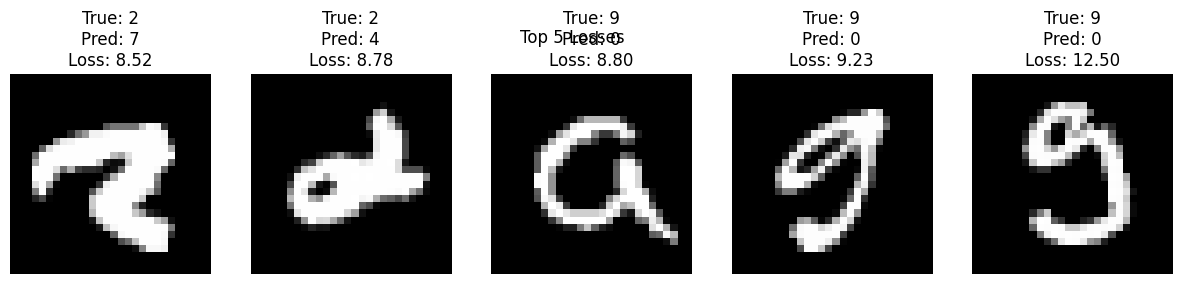

In [98]:
images, preds, labels, losses = metrics(data_module.test_dataloader(),model)

top_losses_vis(hyperparameters, top_loss_indices,
                   images, preds, labels, losses)

In [95]:
def metrics(dataloader,model):
    # Collect images, predictions, and losses
    images = []
    preds = []
    labels = []
    losses = []
    for batch in dataloader:
        x, y = batch
        with torch.no_grad():
            h = model(x)
            loss = nn.CrossEntropyLoss(reduction='none')(h, y)
            pred = torch.argmax(h, dim=1)
        images.extend(x.cpu())
        preds.extend(pred.cpu().numpy())
        labels.extend(y.cpu().numpy())
        losses.extend(loss.cpu().numpy())
    return images, preds, labels, losses

def top_losses_vis(hyperparameters, top_loss_indices,
                   images, preds, labels, losses):
    num_imgs = hyperparameters['num_samples_vis']
    # Find top num_imgs losses
    top_loss_indices = np.argsort(losses)[-num_imgs:]

    plt.figure(figsize=(num_imgs*3, 3))
    for i, idx in enumerate(top_loss_indices):
        plt.subplot(1, num_imgs, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f'True: {labels[idx]}\nPred: {preds[idx]}\nLoss: {losses[idx]:.2f}')
        plt.axis('off')
    plt.suptitle('Top 5 Losses')
    plt.show()


def conf_mat(figsize):
    # Plot confusion matrix
    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()






# # Collect all predictions and labels
# all_preds = []
# all_labels = []
# for batch in data_module.test_dataloader():
#     x, y = batch
#     with torch.no_grad():
#         y_hat = model(x)
#         preds = torch.argmax(y_hat, dim=1)
#     all_preds.extend(preds.cpu().numpy())
#     all_labels.extend(y.cpu().numpy())

# # Compute confusion matrix
# cm = confusion_matrix(all_labels, all_preds)




# # ### Plot Top Losses

# # %%
# # Collect images, predictions, and losses
# images = []
# preds = []
# labels = []
# losses = []
# for batch in data_module.test_dataloader():
#     x, y = batch
#     with torch.no_grad():
#         y_hat = model(x)
#         loss = nn.CrossEntropyLoss(reduction='none')(y_hat, y)
#         pred = torch.argmax(y_hat, dim=1)
#     images.extend(x.cpu())
#     preds.extend(pred.cpu().numpy())
#     labels.extend(y.cpu().numpy())
#     losses.extend(loss.cpu().numpy())

# # Find top 5 losses
# top_loss_indices = np.argsort(losses)[-5:]

# # Plot top losses
# plt.figure(figsize=(15, 3))
# for i, idx in enumerate(top_loss_indices):
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(images[idx].squeeze(), cmap='gray')
#     plt.title(f'True: {labels[idx]}\nPred: {preds[idx]}\nLoss: {losses[idx]:.2f}')
#     plt.axis('off')
# plt.suptitle('Top 5 Losses')
# plt.show()

# Dataset and data loaders

In [61]:
data_module = MNISTDataModule(hyperparameters['bs'], mean, std,
                              hyperparameters['num_samples'])

# Train the model

Initialization of the dataset, the dataloader, and the training module

In [80]:
loss_fn = losses_dict[hyperparameters['criterion']]
model = train_model(MLP(hyperparameters['im_size']**2,
                        hyperparameters['n_classes']),
                    loss_fn, hyperparameters['lr'])
trainer = Trainer(max_epochs=hyperparameters['num_epochs'],
                  accelerator="auto", devices="auto")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Train the model

In [81]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 109 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


# Test the model

The Metric and the loss values for the test set (for a batch)

In [82]:
test_results = trainer.test(model, datamodule=data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9129999876022339     │
│         test_loss         │    0.31381139159202576    │
└───────────────────────────┴───────────────────────────┘

The metrics for the entire test set

In [ ]:
test_labels, test_preds, test_losses, test_imgs,
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Find top num_imgs losses
top_loss_indices = np.argsort(test_losses)[-hyperparameters['num_samples_vis']:]

Visualize the test results

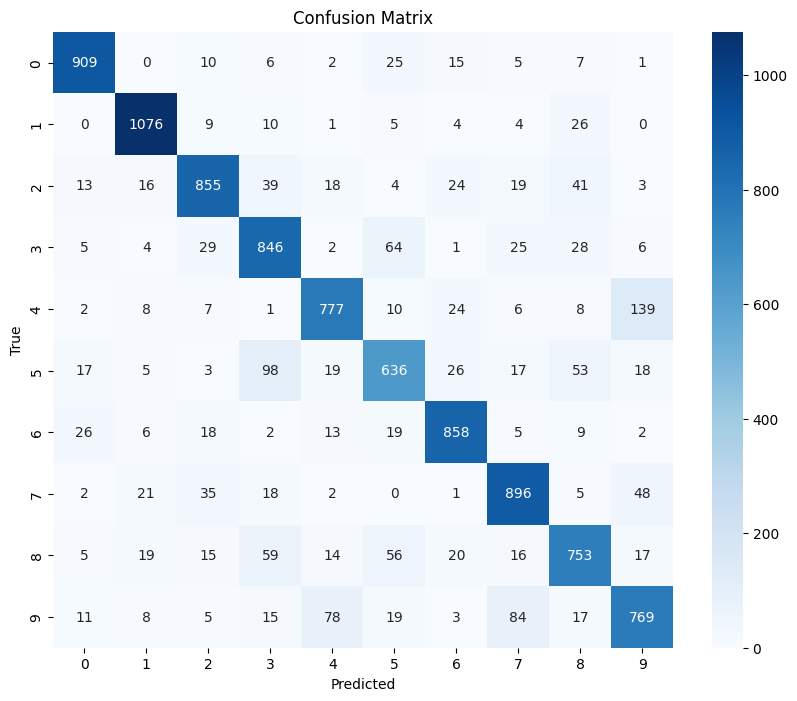

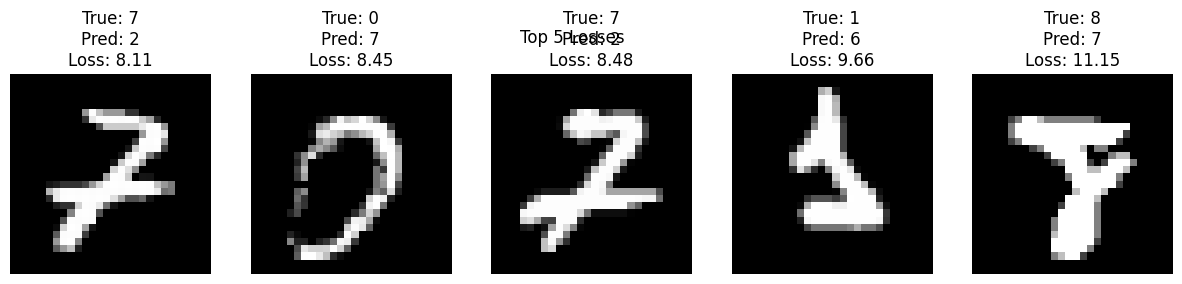

In [30]:
# Collect all predictions and labels
all_preds = []
all_labels = []
for batch in data_module.test_dataloader():
    x, y = batch
    with torch.no_grad():
        y_hat = model(x)
        preds = torch.argmax(y_hat, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# ### Plot Top Losses

# %%
# Collect images, predictions, and losses
images = []
preds = []
labels = []
losses = []
for batch in data_module.test_dataloader():
    x, y = batch
    with torch.no_grad():
        y_hat = model(x)
        loss = nn.CrossEntropyLoss(reduction='none')(y_hat, y)
        pred = torch.argmax(y_hat, dim=1)
    images.extend(x.cpu())
    preds.extend(pred.cpu().numpy())
    labels.extend(y.cpu().numpy())
    losses.extend(loss.cpu().numpy())

# Find top 5 losses
top_loss_indices = np.argsort(losses)[-5:]

# Plot top losses
plt.figure(figsize=(15, 3))
for i, idx in enumerate(top_loss_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title(f'True: {labels[idx]}\nPred: {preds[idx]}\nLoss: {losses[idx]:.2f}')
    plt.axis('off')
plt.suptitle('Top 5 Losses')
plt.show()

# Save the results

Save the model

In [28]:
task.update_output_model(model_path="mnist_mlp_model.pth")
torch.save(model.state_dict(), "mnist_mlp_model.pth")

2025-01-07 13:42:25,469 - clearml.storage - ERROR - Exception encountered while uploading [Errno 2] No such file or directory: 'mnist_mlp_model.pth'
2025-01-07 13:42:25,472 - clearml.Task - INFO - Failed model upload


Stop logging

In [29]:
task.close()

In [ ]:
# %% [markdown]
# # MNIST Classification with PyTorch Lightning and ClearML
#
# This notebook demonstrates how to classify MNIST digits using PyTorch Lightning and log experiments with ClearML.

# %% [markdown]
# ## Step 1: Set Up ClearML Task
#
# ClearML helps in tracking experiments, logging metrics, and storing models.

# %% [markdown]
# ## Step 2: Define the Data Module
#
# We'll use PyTorch Lightning's `LightningDataModule` to handle data loading and preprocessing.

# %%
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        # Download MNIST dataset
        datasets.MNIST(root='./data', train=True, download=True)
        datasets.MNIST(root='./data', train=False, download=True)

    def setup(self, stage=None):
        # Split dataset into train and validation sets
        mnist_full = datasets.MNIST(root='./data', train=True, transform=self.transform)
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        self.mnist_test = datasets.MNIST(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

# %% [markdown]
# ## Step 3: Define the Model
#
# We'll create a simple convolutional neural network (CNN) for MNIST classification.

# %%
class MNISTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# %% [markdown]
# ## Step 4: Train the Model
#
# We'll use PyTorch Lightning's `Trainer` to handle training and validation.

# %%
# Initialize data module and model
data_module = MNISTDataModule()
model = MNISTModel()

# Initialize PyTorch Lightning Trainer
trainer = Trainer(max_epochs=2, accelerator="auto", devices="auto")

# Train the model
trainer.fit(model, data_module)

# %% [markdown]
# ## Step 5: Test the Model
#
# After training, we'll evaluate the model on the test set.

# %%
# Test the model
trainer.test(model, datamodule=data_module)

# %% [markdown]
# ## Step 6: Log Model with ClearML
#
# Finally, we'll log the trained model using ClearML.

# %%
# Log the trained model
task.update_output_model(model_path="mnist_model.pth")
torch.save(model.state_dict(), "mnist_model.pth")

# %% [markdown]
# ## Conclusion
#
# This notebook demonstrated how to:
# 1. Set up a ClearML task for experiment tracking.
# 2. Use PyTorch Lightning for data loading and model training.
# 3. Train and test a simple CNN on the MNIST dataset.
# 4. Log the trained model using ClearML.
#
# You can now explore the ClearML dashboard to analyze metrics, compare experiments, and manage models.

In [ ]:
task.close()

# Questions

* Explain the architecture of the MLP model used in this lab. What are the dimensions of the input layer, hidden layers, and output layer? Why is the input size `28 * 28` for the MNIST dataset?

* What loss function is used in this lab, and why is it suitable for this task? Which optimizer is used, and what is its learning rate?

* What transformations are applied to the MNIST dataset before training? Why is normalization important, and what values are used for normalization in this lab?

* How is accuracy calculated during the testing phase? What does the confusion matrix represent, and how can it help in evaluating the model's performance?

* What does the "Top Losses" visualization represent? How can it help in debugging or improving the model?


### Bonus Questions (Optional)
* What is the purpose of using ClearML in this lab? How does it help in managing machine learning experiments?
